In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from AnastrisTNG import TNGsimulation # https://github.com/wx-ys/AnastrisTNG

from galpos import GalaxyPoseTrajectory
from galpos import pynbody_decorate

In [2]:
with h5py.File("TNG50_subhalo_10.hdf5", "r") as file:
    ID = 10
    snap_all = list(file[f"{ID}"].keys())
    snap_all = np.sort(np.int16(snap_all))
    align = np.array([file[f"{ID}/{i}"]['align'][...] for i in snap_all])  # angular momentum of this material
    a = np.array([file[f"{ID}/{i}"]['a'][...] for i in snap_all])           # scale factor
    ang_mom = np.array([file[f"{ID}/{i}"]['ang_mom'][...] for i in snap_all])# angular momentum
    cpos = np.array([file[f"{ID}/{i}"]['cpos'][...] for i in snap_all])     # comoving position  "a kpc"
    cvel = np.array([file[f"{ID}/{i}"]['cvel'][...] for i in snap_all])     # comoving velocity "a kpc/Gyr"
    t = np.array([file[f"{ID}/{i}"]['t'][...] for i in snap_all])           # time "Gyr"
    re = np.array([file[f"{ID}/{i}"]['re'][...] for i in snap_all])         # effective radius "kpc" used to determine ang_mom and center velocity

In [3]:
# build galaxy pose trajectory model
# box_size of TNG50 is 35000 "a kpc/h" = 35000/0.6774 "a kpc"
orbits = GalaxyPoseTrajectory(t, cpos, cvel, angular_momentum=ang_mom, box_size=35000/0.6774)

here show the pose and trajectory evolution of this galaxy

In [4]:
t_test = np.linspace(t[0],t[-1],100)
p,v,tr = orbits(t_test,wrap=True)

Text(0, 0.5, 'Position [a kpc]')

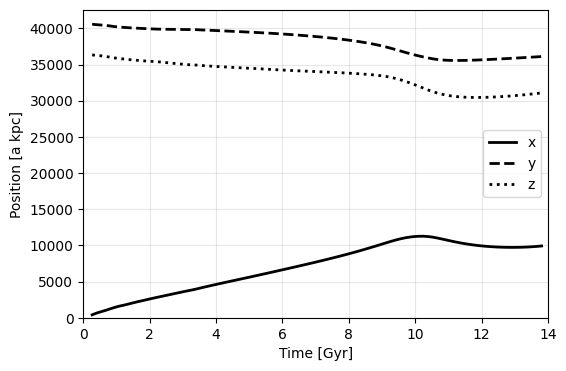

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(t_test, p[:, 0], 'k-', linewidth=2, label='x')
plt.plot(t_test, p[:, 1], 'k--', linewidth=2, label='y')
plt.plot(t_test, p[:, 2], 'k:', linewidth=2, label='z')
plt.legend()
plt.xlim(0, 14)
plt.ylim(0,)
plt.grid(True, alpha=0.3)
plt.xlabel("Time [Gyr]")
plt.ylabel("Position [a kpc]")

Text(0, 0.5, 'Velocity [a kpc / Gyr]')

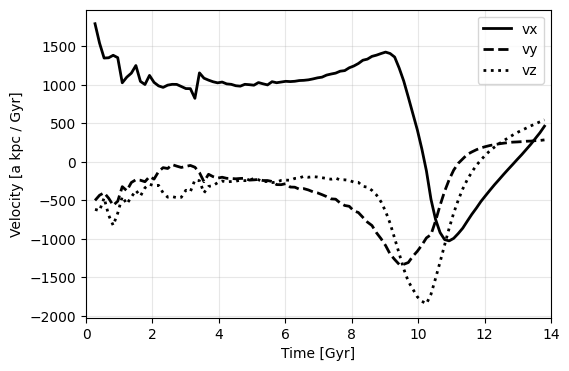

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(t_test, v[:, 0], 'k-', linewidth=2, label='vx')
plt.plot(t_test, v[:, 1], 'k--', linewidth=2, label='vy')
plt.plot(t_test, v[:, 2], 'k:', linewidth=2, label='vz')
plt.legend()
plt.xlim(0, 14)
plt.grid(True, alpha=0.3)
plt.xlabel("Time [Gyr]")
plt.ylabel("Velocity [a kpc / Gyr]")

Text(0, 0.5, 'Orientation')

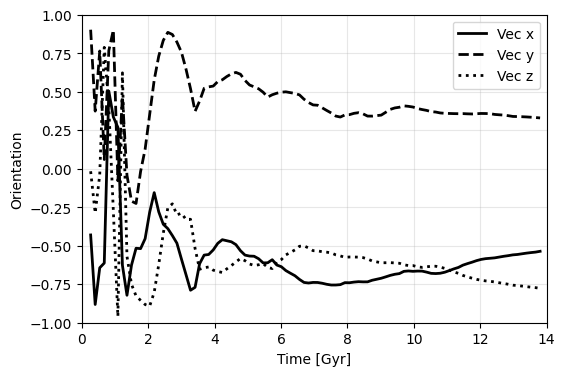

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(t_test, tr[:,2][:, 0], 'k-', linewidth=2, label='Vec x')
plt.plot(t_test, tr[:,2][:, 1], 'k--', linewidth=2, label='Vec y')
plt.plot(t_test, tr[:,2][:, 2], 'k:', linewidth=2, label='Vec z')
plt.ylim(-1,1)
plt.xlim(0,14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlabel("Time [Gyr]")
plt.ylabel("Orientation")

In [7]:
path = '/home/yxi/Simulation/sims/TNG50-1/output'
snap = 99
snapshot = TNGsimulation.Snapshot(path,snap)
snapshot.load_particle_para['star_fields'] = ['GFM_StellarFormationTime','BirthPos','BirthVel','GFM_InitialMass',]
sub = snapshot.load_particle(ID)

In [ ]:
# extract birth properties
birth_pos = sub.s['BirthPos'].in_units('a kpc').view(np.ndarray)                # "a kpc"
birth_vel = sub.s['BirthVel'].in_units('kpc Gyr**-1 a**1/2').view(np.ndarray)
birth_mass = sub.s['GFM_InitialMass'].in_units('Msol').view(np.ndarray)
mass = sub.s['mass'].in_units('Msol').view(np.ndarray)
age = sub.s['age'].in_units('Gyr').view(np.ndarray)
aform = sub.s['aform'].view(np.ndarray)
tform = sub.s['tform'].in_units('Gyr').view(np.ndarray)

In [ ]:

birth = pynbody_decorate.make_star_birth(orbits, birth_pos = birth_pos, mass = mass,birth_velocity = birth_vel, birth_time = tform,
                  birth_pos_units = "a kpc", birth_velocity_units = 'kpc Gyr**-1 a**1/2', scale_factor = aform)

In [12]:
# transform birth properties to the galaxy's frame
birth.align_with_galaxy(orientation_align=True) 

In [13]:
sub.physical_units()
tr = sub.face_on(rmax=8,alignwith="star")

In [14]:
from gal3d.visualization.hist2d import hist_2d,show_image # used to show image

In [21]:
l = 20

im_face_birth = hist_2d(birth.s['pos'][:,0], birth.s['pos'][:,1],weights=birth.s['mass'],x_range=(-l,l),y_range=(-l,l),nbins=200)
im_edge_birth = hist_2d(birth.s['pos'][:,0], birth.s['pos'][:,2],weights=birth.s['mass'],x_range=(-l,l),y_range=(-l,l),nbins=200)

im_face_cur = hist_2d(sub.s['pos'][:,0], sub.s['pos'][:,1],weights=sub.s['mass'],x_range=(-l,l),y_range=(-l,l),nbins=200)
im_edge_cur = hist_2d(sub.s['pos'][:,0], sub.s['pos'][:,2],weights=sub.s['mass'],x_range=(-l,l),y_range=(-l,l),nbins=200)

Text(0.5, 1.0, 'Edge-on view of birth')

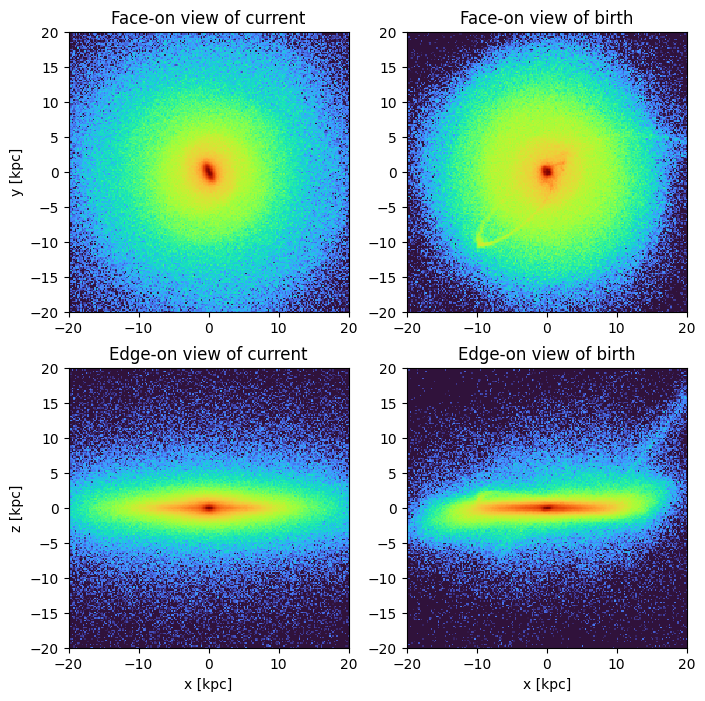

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))


im1 = show_image(im_face_cur,axesObj=ax[0, 0],cmap='turbo')
#im1.axes.set_xlabel("x [kpc]")
im1.axes.set_ylabel("y [kpc]")
im1.axes.set_title("Face-on view of current")


im2 = show_image(im_face_birth,axesObj=ax[0, 1], cmap='turbo')
#im2.axes.set_xlabel("x [kpc]")
#im2.axes.set_ylabel("y [kpc]")
im2.axes.set_title("Face-on view of birth")

im3 = show_image(im_edge_cur,axesObj=ax[1, 0],cmap='turbo')
im3.axes.set_xlabel("x [kpc]")
im3.axes.set_ylabel("z [kpc]")
im3.axes.set_title("Edge-on view of current")


im4 = show_image(im_edge_birth,axesObj=ax[1, 1],cmap='turbo')
im4.axes.set_xlabel("x [kpc]")
#im4.axes.set_ylabel("z [kpc]")
im4.axes.set_title("Edge-on view of birth")